# MLP 1 - MNIST

In [1]:
import numpy as np
import cupy as cp
import pathlib
import pickle
import csv
import sys

In [2]:
sys.path.append(str(pathlib.Path('../../').resolve()))

In [3]:
from lib.experiments import train_test_experiment, build_MLP, build_augmentation_pipeline
from lib.utils.enums import NonLinearity, Initialization, Dataset, OptimizerName
from lib.utils.data import load_integer_dataset

## Experiments config

In [5]:
num_fc_layers = 3
num_fc_hidden = [100, 50]

In [6]:
dataset_config = dict(
    dataset=Dataset.MNIST.name,
    subsample_ratio=1.0,
    ohe_values=(0, 32),
    data_augmentation=False,
    normalize=True,
)

In [7]:
network_config = dict(
    num_fc_layers=num_fc_layers,
    num_fc_hidden=num_fc_hidden,
    non_linearity=NonLinearity.NITRO_LEAKY_RELU.name,
    init=Initialization.UNIFORM_KAIMING_LEAKY_RELU.name,
    dropout_rate=0.0,
    seed=42,
    dtype='int32',
    device='cuda',
    local_loss='pred',
    bias=False,
    debug=False,
)

In [8]:
training_config = dict(
    batch_size=64,
    num_epochs=150,
    lr_inv=512,
    lr_amp_factor=640,
    fwd_decay_inv=12_000,
    subnet_decay_inv=3000,
    optimizer=OptimizerName.INTEGER_SGD.name,
)

In [9]:
config = dataset_config | network_config | training_config

## Run the configuration

Training on 60000 samples
Data normalized. New statistics:
-  Min: -31
-  Max: 127
- Mean: -7
-  Std: 53

Moved data to device: <CUDA Device 1>
Train set:  (60000, 1, 28, 28), (60000, 10)
Test set:   (10000, 1, 28, 28), (10000, 10)
Data types: (int8, int8)


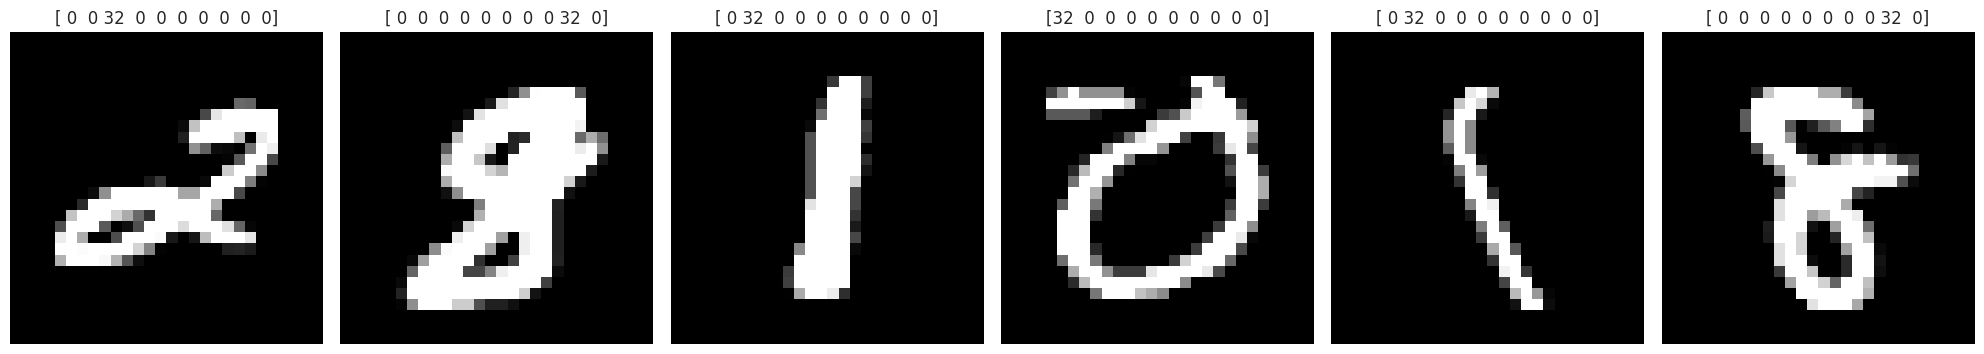

In [10]:
# Show the data and the model
dataset = load_integer_dataset(config, ohe_values=config["ohe_values"], val_dim=0, show_images=True, data_path='../.data')
X_train, _, _, y_train, _, _ = dataset

In [11]:
model = build_MLP(config, X_tr=X_train, y_tr=y_train)
print(model.extra_repr(1))

IntegerLocalLossMLP(
	(0): Sequential(
			(0): Flatten()
			(1): LocalLinearBlock(
			(0): IntegerLinear(in_features=784, out_features=100, bias=False, decay_rate_inv=10000)
			(1): ConstantScaling(fwd_factor=200704, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): IntegerLinear(in_features=100, out_features=10, bias=False, decay_rate_inv=3500)
			(1): ConstantScaling(fwd_factor=25600, bwd_factor=1)
		)
	)
			(2): LocalLinearBlock(
			(0): IntegerLinear(in_features=100, out_features=50, bias=False, decay_rate_inv=10000)
			(1): ConstantScaling(fwd_factor=25600, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): IntegerLinear(in_features=50, out_features=10, bias=False, decay_rate_inv=3500)
			(1): ConstantScaling(fwd_factor=12800, bwd_factor=1)
		)
	)
			(3): Sequential(
			(0): IntegerLinear(in_features=50, out_features=10, bias=False, decay_rate_inv=3500)
			(1): ConstantScaling(fwd_

In [12]:
def run_experiment(exp_config):
    # Setup reproducibility
    print(f"{'-' * 64}")
    print(f"Running experiment with seed {exp_config['seed']}...")
    np.random.seed(exp_config["seed"])
    cp.random.seed(exp_config["seed"])
    
    # Load the dataset
    data = load_integer_dataset(exp_config, ohe_values=exp_config["ohe_values"], val_dim=0, show_images=False, show_log=False, data_path='../.data')
    X_tr, _, X_test, y_tr, _, y_test = data

    # Setup data augmentation
    augmentation_pipeline = build_augmentation_pipeline(exp_config)

    # Build and train the model
    m = build_MLP(exp_config, X_tr=X_tr, y_tr=y_tr)    
    best_train_acc, best_test_acc = train_test_experiment(
        m, exp_config, X_tr=X_tr, X_te=X_test, y_tr=y_tr, y_te=y_test,
        augmentation_pipeline=augmentation_pipeline,
        show_local_accuracies=False, show_progress_bar=False
    )

    # Append the results to a CSV file
    with open('./results.csv', mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([exp_config["seed"], best_train_acc, best_test_acc])
        
    # Save the first model
    if not pathlib.Path('model.pkl').exists():
        with open('model.pkl', 'wb') as f:
            pickle.dump(model, f)

In [13]:
N_EXPERIMENTS = 10
for i in range(N_EXPERIMENTS):
    run_experiment(config)
    config["seed"] += 1

----------------------------------------------------------------
Running experiment with seed 42...
Epoch   1/150 - Train accuracy: 50.312% - Test accuracy: 88.291%
Epoch   2/150 - Train accuracy: 90.343% - Test accuracy: 91.877%
Epoch   3/150 - Train accuracy: 92.208% - Test accuracy: 93.049%
Epoch   4/150 - Train accuracy: 93.283% - Test accuracy: 93.970%
Epoch   5/150 - Train accuracy: 94.105% - Test accuracy: 94.441%
Epoch   6/150 - Train accuracy: 94.682% - Test accuracy: 94.712%
Epoch   7/150 - Train accuracy: 95.139% - Test accuracy: 94.942%
Epoch   8/150 - Train accuracy: 95.463% - Test accuracy: 95.192%
Epoch   9/150 - Train accuracy: 95.774% - Test accuracy: 95.603%
Epoch  10/150 - Train accuracy: 95.985% - Test accuracy: 95.573%
Epoch  11/150 - Train accuracy: 96.190% - Test accuracy: 95.853%
Epoch  12/150 - Train accuracy: 96.353% - Test accuracy: 96.204%
Epoch  13/150 - Train accuracy: 96.518% - Test accuracy: 96.204%
Epoch  14/150 - Train accuracy: 96.695% - Test accuracy

## Aggregated results

In [14]:
with open('results.csv', mode='r') as file:
    results = np.array(list(csv.reader(file)), dtype=np.float32)

In [15]:
# Compute mean and standard deviation
mean_train_acc = np.mean(results[:,1])
std_train_acc = np.std(results[:,1])
mean_test_acc = np.mean(results[:,2])
std_test_acc = np.std(results[:,2])

In [16]:
print("Mean results with 95% confidence interval:")
print(f"- Train accuracy: {mean_train_acc:.2%} ± {std_train_acc * 2:.2%}")
print(f"-  Test accuracy: {mean_test_acc:.2%} ± {std_test_acc * 2:.2%}")

Mean results with 95% confidence interval:
- Train accuracy: 97.98% ± 0.13%
-  Test accuracy: 97.24% ± 0.21%
